In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [10]:
# !pip show nest_asyncio kaggle > /dev/null || install --upgrade -q nest_asyncio kaggle

In [11]:
import os
import cv2
import glob
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import multiprocessing
import tensorflow as tf
from pathlib import Path
import concurrent.futures
import keras.backend as K
from time import perf_counter
from functools import lru_cache
import matplotlib.pyplot as plt
from keras import layers, models
from keras.optimizers import Adam
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import LearningRateScheduler
from keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import accuracy_score, classification_report

In [12]:
# Set global options for TensorFlow to optimize performance
try:
    tf.config.optimizer.set_jit(True)
    print("Just-In-Time (JIT) compilation has been enabled.")
except Exception as e:
    print("Could not enable Just-In-Time (JIT) compilation: ", e)

try:
    tf.config.threading.set_inter_op_parallelism_threads(4)
    print("Inter operation parallelism threads set to 4.")
except Exception as e:
    print("Could not set Inter operation parallelism threads: ", e)

try:
    tf.config.threading.set_intra_op_parallelism_threads(4)
    print("Intra operation parallelism threads set to 4.")
except Exception as e:
    print("Could not set Intra operation parallelism threads: ", e)

Just-In-Time (JIT) compilation has been enabled.
Inter operation parallelism threads set to 4.
Intra operation parallelism threads set to 4.


In [13]:
# Configure GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
#         tf.config.experimental.set_memory_growth(physical_devices[1], True)

        print("Memory growth has been enabled on the first GPU.")
    except:
        # Print error message if not able to configure the GPU
        print("Could not set memory growth.")
else:
    print("No GPU detected.")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth has been enabled on the first GPU.


In [14]:
# Enable mixed precision training
try:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision training has been enabled.")
except Exception as e:
    print("Could not enable mixed precision training: ", e)

Mixed precision training has been enabled.


In [15]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")


Skipping, found downloaded files in "./brain-tumor-classification-mri" (use force=True to force download)


In [16]:
# dataset = Path(r"C:\Users\ashva\Work\Projects\researchAI\Brain Tumor Detection\datasets")
dataset = Path(r"/content/brain-tumor-classification-mri") # colab
# dataset = Path(r"/kaggle/input/") # kaggle
# brain_T = dataset / "brain-tumor-classification-mri" # kaggle

In [17]:
def collect_data(dataset_root):
    """
    Collects image data and labels from the dataset directory.

    Args:
        dataset_root (str): Path to the root directory of the dataset.

    Returns:
        list: A list of dictionaries, each containing 'image_path' and 'label' keys.
        list: A list of class names.
    """
    class_indices = {}  # Dictionary to map class names to indices
    data = []           # List of data entries
    class_names = []    # List of class names

    for split in ["Training", "Testing"]: # colab
    # for split in os.listdir(dataset_root): # kaggle
        split_dir = os.path.join(dataset_root, split)
        if not os.path.isdir(split_dir):
            continue

        for class_idx, class_name in enumerate(os.listdir(split_dir)):
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            if class_name not in class_indices:
                class_indices[class_name] = len(class_indices)
                class_names.append(class_name)

            for image_name in os.listdir(class_dir):
                if image_name.endswith(('.jpg', '.png')):
                    image_path = os.path.join(class_dir, image_name)
                    data.append({"image_path": image_path, "label": class_indices[class_name]})

    return data, class_names

# data, class_names = collect_data(brain_T) # kaggle
data, class_names = collect_data(dataset) # colab

In [18]:
# Extract image paths and labels from the data dictionary
image_paths = [entry["image_path"] for entry in data]
labels = [entry["label"] for entry in data]

def format_class_name(class_name):
    """
    Format the class name by capitalizing the first letter of each word.

    Parameters:
        class_name (str): The original class name.

    Returns:
        str: The formatted class name.
    """
    words = class_name.split('_')
    formatted_name = ' '.join([word.capitalize() for word in words])
    return formatted_name

formatted_class_names = [format_class_name(class_name) for class_name in class_names]

In [19]:
def is_black_and_white(image_path, label):
    """
    Process a single image and determine its color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if image.mode == '1' else 'Colored'
    return label, color_type

In [20]:
def count_images_per_class(image_paths, labels, class_names):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        class_names (dict): Dictionary mapping original class names to formatted class names.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    # Process images in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(is_black_and_white, image_paths, labels), total=len(image_paths), desc="Processing images"))

    # Update counts based on processed results
    for label, color_type in processed_results:
        data[class_names[label]][color_type] += 1

    # Create DataFrame from the counts data
    df_data = {'Class': [], 'Black & White': [], 'Colored': []}
    for class_name, counts in data.items():
        df_data['Class'].append(class_name)
        df_data['Black & White'].append(counts['Black & White'])
        df_data['Colored'].append(counts['Colored'])

    df = pd.DataFrame(df_data)
    return df

# Count images per class and display the results
result_df = count_images_per_class(image_paths, labels, formatted_class_names)
print(result_df)

Processing images: 100%|██████████| 3264/3264 [00:00<00:00, 11969.78it/s]

              Class  Black & White  Colored
0      Glioma Tumor              0      926
1  Meningioma Tumor              0      937
2          No Tumor              0      500
3   Pituitary Tumor              0      901


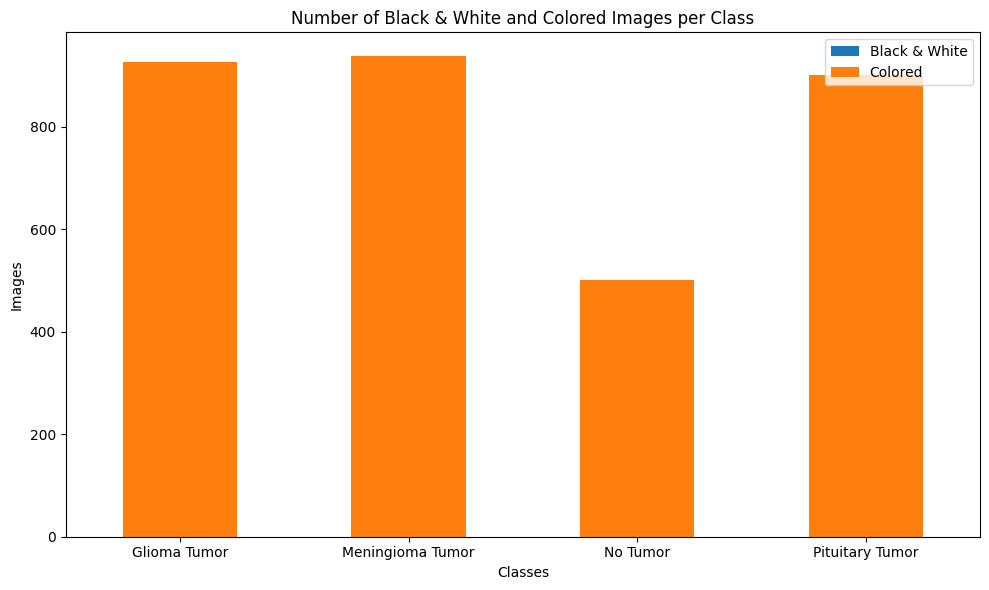

In [21]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    # Set the 'Class' column as the DataFrame index for easy plotting
    result_df.set_index(class_column, inplace=True)

    # Plotting the data
    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 139.77it/s]


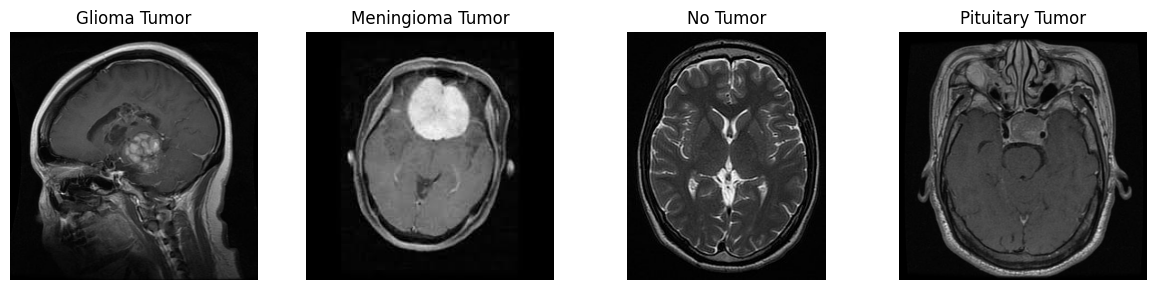

In [22]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels, class_names):
    """
    Display images grouped by class labels.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        class_names (dict): Dictionary mapping original class names to formatted class names.
    """
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    # Calculate the number of rows and columns dynamically
    num_rows = num_classes // 3  # Assuming you want at most 3 columns
    num_cols = min(4, num_classes)  # Maximum 3 columns

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    # Flatten the axs array if num_rows is 1
    if num_rows == 1:
        axs = [axs]

    # Use tqdm to display progress bar
    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            if i >= num_classes:
                break  # In case there are more classes than subplots

            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols][i % num_cols]
                ax.imshow(selected_image, cmap='gray')  # Change cmap if needed
                ax.set_title(class_names[class_label])  # Use the formatted class name
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)  # Update the progress bar

    plt.tight_layout()
    plt.show()

# Display images per class
display_images_per_class(image_paths, labels, formatted_class_names)

In [23]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

In [24]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths,
                                                                      labels_encoded,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      stratify=labels_encoded)

train_paths, test_paths, train_labels, test_labels= train_test_split(train_paths,
                                                                    train_labels,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=train_labels)

In [25]:
train_paths_aug, train_paths_no_aug, train_labels_aug, train_labels_no_aug = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)


In [26]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})


In [27]:
class_indices = train_df.groupby('Labels').apply(lambda x: x.index.tolist()).to_dict()

# Calculate the number of samples to augment (20% of each class)
num_augmented_samples_per_class = {
    label: int(1 * len(indices)) for label, indices in class_indices.items()
}

# Create ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    brightness_range=[0.7, 1.3]
)

augmented_images_paths = []
augmented_labels = []

# Generate augmented images for each class (20% of each)
for label, indices in class_indices.items():
    num_samples = num_augmented_samples_per_class[label]
    sampled_indices = np.random.choice(indices, num_samples, replace=False)
    sampled_paths = train_df.iloc[sampled_indices]['File Paths'].tolist()

    # Append augmented image paths
    augmented_images_paths.extend(sampled_paths)
    augmented_labels.extend([label] * num_samples)

# Concatenate augmented image paths and labels with the original training data
merged_train_images_paths = np.concatenate([train_df['File Paths'].values, augmented_images_paths], axis=0)
merged_train_labels = np.concatenate([train_df['Labels'], augmented_labels], axis=0)
shuffled_indices = np.random.permutation(len(merged_train_images_paths))

merged_train_images_paths = merged_train_images_paths[shuffled_indices]
merged_train_labels = merged_train_labels[shuffled_indices]

In [28]:
len(merged_train_images_paths)

4176

In [29]:
len(augmented_labels)

2088

In [30]:
merged_train_df = pd.DataFrame({
    'File Paths': np.concatenate([train_df['File Paths'].values, augmented_images_paths], axis=0),
    'Labels': np.concatenate([train_df['Labels'], augmented_labels], axis=0)
})

# Shuffle the DataFrame
merged_train_df = merged_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the shuffled DataFrame


In [31]:
print(len(merged_train_df))

4176


Before Augmentation

In [32]:
train_df = pd.DataFrame({'File Paths': train_paths, 'Labels': train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

train_percentage = (total_train_samples / len(labels_encoded)) * 100
val_percentage = (total_val_samples / len(labels_encoded)) * 100
test_percentage = (total_test_samples / len(labels_encoded)) * 100

train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

train_df.index = val_df.index = test_df.index = formatted_class_names

print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 2088
Total Validation Samples: 653
Total Test Samples: 523

Percentage of Split:
Train: 63.97%
Validation: 20.01%
Test: 16.02%

Class Distribution:
                  Train Samples  Validation Samples  Test Samples
Glioma Tumor                592                 185           149
Meningioma Tumor            599                 188           150
No Tumor                    320                 100            80
Pituitary Tumor             577                 180           144


After Augmentation

In [33]:
import pandas as pd
import numpy as np

# Assuming you have merged_train_images_paths, merged_train_labels, val_paths, val_labels, test_paths, test_labels

# Create DataFrames for train, validation, and test data
train_df = pd.DataFrame({'File Paths': merged_train_images_paths, 'Labels': merged_train_labels})
val_df = pd.DataFrame({'File Paths': val_paths, 'Labels': val_labels})
test_df = pd.DataFrame({'File Paths': test_paths, 'Labels': test_labels})

# Calculate total samples
total_train_samples = len(train_df)
total_val_samples = len(val_df)
total_test_samples = len(test_df)

# Calculate percentages
total_samples = total_train_samples + total_val_samples + total_test_samples
train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Get class distribution for train, validation, and test
train_counts = train_df['Labels'].value_counts().sort_index()
val_counts = val_df['Labels'].value_counts().sort_index()
test_counts = test_df['Labels'].value_counts().sort_index()

# Update existing DataFrames with class distribution
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})

# Set index for DataFrames
formatted_class_names = ['No Tumor', 'Meningioma Tumor', 'Glioma Tumor','Pituitary Tumor']  # Replace with your class names
train_df.index = val_df.index = test_df.index = formatted_class_names

# Print statistics
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)


Total Train Samples: 4176
Total Validation Samples: 653
Total Test Samples: 523

Percentage of Split:
Train: 78.03%
Validation: 12.20%
Test: 9.77%

Class Distribution:
                  Train Samples  Validation Samples  Test Samples
No Tumor                   1184                 185           149
Meningioma Tumor           1198                 188           150
Glioma Tumor                640                 100            80
Pituitary Tumor            1154                 180           144


In [34]:
def image_generator(img_paths, img_labels, batch_size):
    """Generator function to load and preprocess images in batches.

    Args:
        img_paths (list): List of image file paths.
        img_labels (list): List of corresponding image labels.
        batch_size (int): Size of the batch.

    Yields:
        tuple: A tuple containing the batch of images and their corresponding labels.
    """
    num_samples = len(img_paths)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = img_paths[offset:offset + batch_size]
            batch_labels = img_labels[offset:offset + batch_size]

            batch_images = []
            for img_path in batch_paths:
                image = cv2.imread(str(img_path))
                resized_image = cv2.resize(image, (224, 224))
                normalized_image = resized_image / 255.0
                batch_images.append(normalized_image)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes)

In [35]:
BATCH_SIZE = 8

train_generator = image_generator(merged_train_images_paths, merged_train_labels, BATCH_SIZE)
train_steps = len(merged_train_labels) // BATCH_SIZE

val_generator = image_generator(val_paths, val_labels, BATCH_SIZE)
val_steps = len(val_paths) // BATCH_SIZE

test_generator = image_generator(test_paths, test_labels, BATCH_SIZE)
test_steps = len(test_paths) // BATCH_SIZE

In [36]:
class AvgTwiceMaxPooling2D(layers.Layer):
    """
    Custom Keras layer that performs average - twice-maximum pooling on the input.

    Args:
        pool_size (int, optional): Pooling window size. Defaults to 2.
        strides (int, optional): Stride size for pooling. Defaults to 2.
        padding (str, optional): Padding mode ('same' or 'valid'). Defaults to 'same'.

    Returns:
        tf.Tensor: Output tensor after applying twice-maximum average pooling.
    """
    def __init__(self, pool_size=2, strides=2, padding='same', **kwargs):
        super(AvgTwiceMaxPooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    @tf.function
    def call(self, inputs, **kwargs):
        """
        Apply the average - twice-maximum pooling operation to the input tensor.

        Args:
            inputs (tf.Tensor): Input tensor.

        Returns:
            tf.Tensor: Output tensor after applying twice-maximum average pooling.
            :param **kwargs:
        """
        # Apply max pooling and average pooling
        max_pooled = layers.MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)
        avg_pooled = layers.AveragePooling2D(pool_size=self.pool_size, strides=self.strides, padding=self.padding)(inputs)

        # Apply the average - twice-maximum pooling operation
        output = tf.subtract(avg_pooled, tf.add(max_pooled, max_pooled))
        return output

In [37]:
def process_image(image_path, p_s, s, p):
    """
    Process an image using layer.

    Args:
        image_path (str): The file path of the input image.
        p_s (tuple): The size of the pooling window (height, width).
        s (int): The stride of the pooling operation.
        p (str): The padding mode for pooling operation ('SAME' or 'VALID').

    Returns:
        tuple: A tuple containing the original image and the processed image after max pooling,
               negative transformation, and twice max-min pooling.
    """
    # Read the image from the file path
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    # Create instances of custom layers
    avgtwicemaxpool_layer = AvgTwiceMaxPooling2D(pool_size=p_s, strides=s, padding=p)

    avgtwicemaxpool_image = avgtwicemaxpool_layer(image_tensor)

    # Squeeze the image tensors to remove the batch dimension
    avgtwicemaxpool_image = np.squeeze(avgtwicemaxpool_image.numpy(), axis=0)

    return image, avgtwicemaxpool_image

def visualize_results(cls_n, *img_t_ps):
    """
    Display images along with titles and corresponding class names in a matplotlib plot.

    Args:
        cls_n (str): Class name for the images.
        *img_t_ps: Variable number of image-title pairs as tuples.

    Raises:
        ValueError: If the number of image-title pairs is not 3.

    Returns:
        None
    """
    # Create a 1x3 subplot for displaying the images
    fig, axes = plt.subplots(1, 2)

    for i, (img_t, ax) in enumerate(zip(img_t_ps, axes)):
        img, title = img_t
        if not isinstance(img, np.ndarray):
            raise TypeError(f"Image {i+1} is not a valid numpy array.")
        if len(img.shape) != 3 or img.shape[2] != 3:
            raise ValueError(f"Image {i+1} is not a valid BGR image.")

        # Display the image and set the title
        ax.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Choose one random image path and its corresponding label
random_index = random.randint(0, len(image_paths) - 1)
random_image_path = image_paths[random_index]
random_label = labels[random_index]

# Process the random image and create image-title pairs
po_si = (3, 3)
st = 2
pa = "SAME"

original_image, twicemaxavg_image = process_image(random_image_path, po_si, st, pa)

# Visualize the results with the class name in the plot title
image_title_pairs = [(original_image, "Original Image"),
                     (twicemaxavg_image, "Avg-2Max Image")]

visualize_results(random_label, *image_title_pairs)

In [39]:
from tensorflow.keras.layers import LeakyReLU


In [40]:
def create_brian_tumor_model(input_shape, n_classes):
    """
    Create a convolutional neural network model optimized for image classification.

    Args:
        input_shape (tuple): Shape of input images (height, width, channels).
        n_classes (int): Number of classes for classification.

    Returns:
        tf.keras.Model: Created CNN model.
    """
    model_name = 'MRINet'

    input_layer = layers.Input(shape=input_shape, name='Input')

    # removed conv layer with 13 filters
    # removed maxpool layer
    blk1 = layers.Conv2D(21, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv1')(input_layer)
    blk1 = layers.BatchNormalization()(blk1)
    blk1 = layers.MaxPooling2D(strides=2, name='MaxPool1')(blk1)

    # removed avgtwicemaxpool layer and 1x1 16 filters layer

    blk2 = layers.Conv2D(34, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv2')(blk1)
    blk2 = layers.BatchNormalization()(blk2)
    blk2 = layers.MaxPooling2D(strides=2, name='MaxPool2')(blk2)

    # removed 1X1 - 64 filters

    avgtwicemax = AvgTwiceMaxPooling2D(pool_size=(3, 3))(blk2)
#     one = layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', name='OneXOne')(avgtwicemax)

    # removed 1-3 cancat layer

    blk3 = layers.Conv2D(55, kernel_size=3, strides=1, padding='same', activation='relu', name='Conv3')(blk2)
    blk3 = layers.MaxPooling2D(strides=2, name='MaxPool3')(blk3) # reshuffled maxpool layer position
#     blk3 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv1')(blk3)
    norm = layers.BatchNormalization()(blk3) # reshuffled batch norm position


    # removed OneXOne-2

    concat = layers.Concatenate(name="VerticalConcat2")([norm, avgtwicemax])

    # concat from 3 to 5
    blk = layers.Conv2D(24, kernel_size=3, strides=1, padding='same', activation='relu', name='ConvC')(norm)
    blk = layers.BatchNormalization()(blk)
    blk = AvgTwiceMaxPooling2D(pool_size=(3, 3))(blk)


    blk4 = layers.Conv2D(89, kernel_size=3, padding='same', activation='relu', name='Conv4')(concat)
#     blk4 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv2')(blk4)
    blk4 = layers.BatchNormalization()(blk4) # reshuffled batch norm position
    blk4 = layers.MaxPooling2D(strides=2, name='MaxPool4')(blk4)

    concat2 = layers.Concatenate(name="VerticalConcat3")([blk4, blk])
    # added block 5
    blk5 = layers.Conv2D(144, kernel_size=3, padding='same', activation='relu', name='Conv5')(concat2)
    blk5 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv3')(blk5)
    blk5 = layers.BatchNormalization()(blk5) # reshuffled batch norm position
    blk5 = layers.MaxPooling2D(strides=2, name='MaxPool5')(blk5)

    # removed avgtwicemaxpool layer and 1x1 64 filters layer

    # removed 3-5 cancat layer

    # removed 1X1 - 92 filters

    # added block 5
    blk6 = layers.Conv2D(233, kernel_size=3, padding='same',  activation=LeakyReLU(alpha=0.01), name='Conv7')(blk5)
    blk6 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv4')(blk6)
#     blk6 = layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(3, 3), padding='same', activation="relu", name='DConv5')(blk6)

    blk6 = layers.BatchNormalization()(blk6) # reshuffled batch norm position

    gap = layers.GlobalAveragePooling2D(name='GAP')(blk6)

    output = layers.Dense(n_classes, activation='softmax', name='Output')(gap)

    model = tf.keras.Model(inputs=input_layer, outputs=output, name=model_name)
    return model

In [41]:
input_shape = (224, 224, 3)
model = create_brian_tumor_model(input_shape, num_classes)
model.summary()

Model: "MRINet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 224, 224, 21)         588       ['Input[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 21)         84        ['Conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 MaxPool1 (MaxPooling2D)     (None, 112, 112, 21)         0         ['batch_normalization[0][

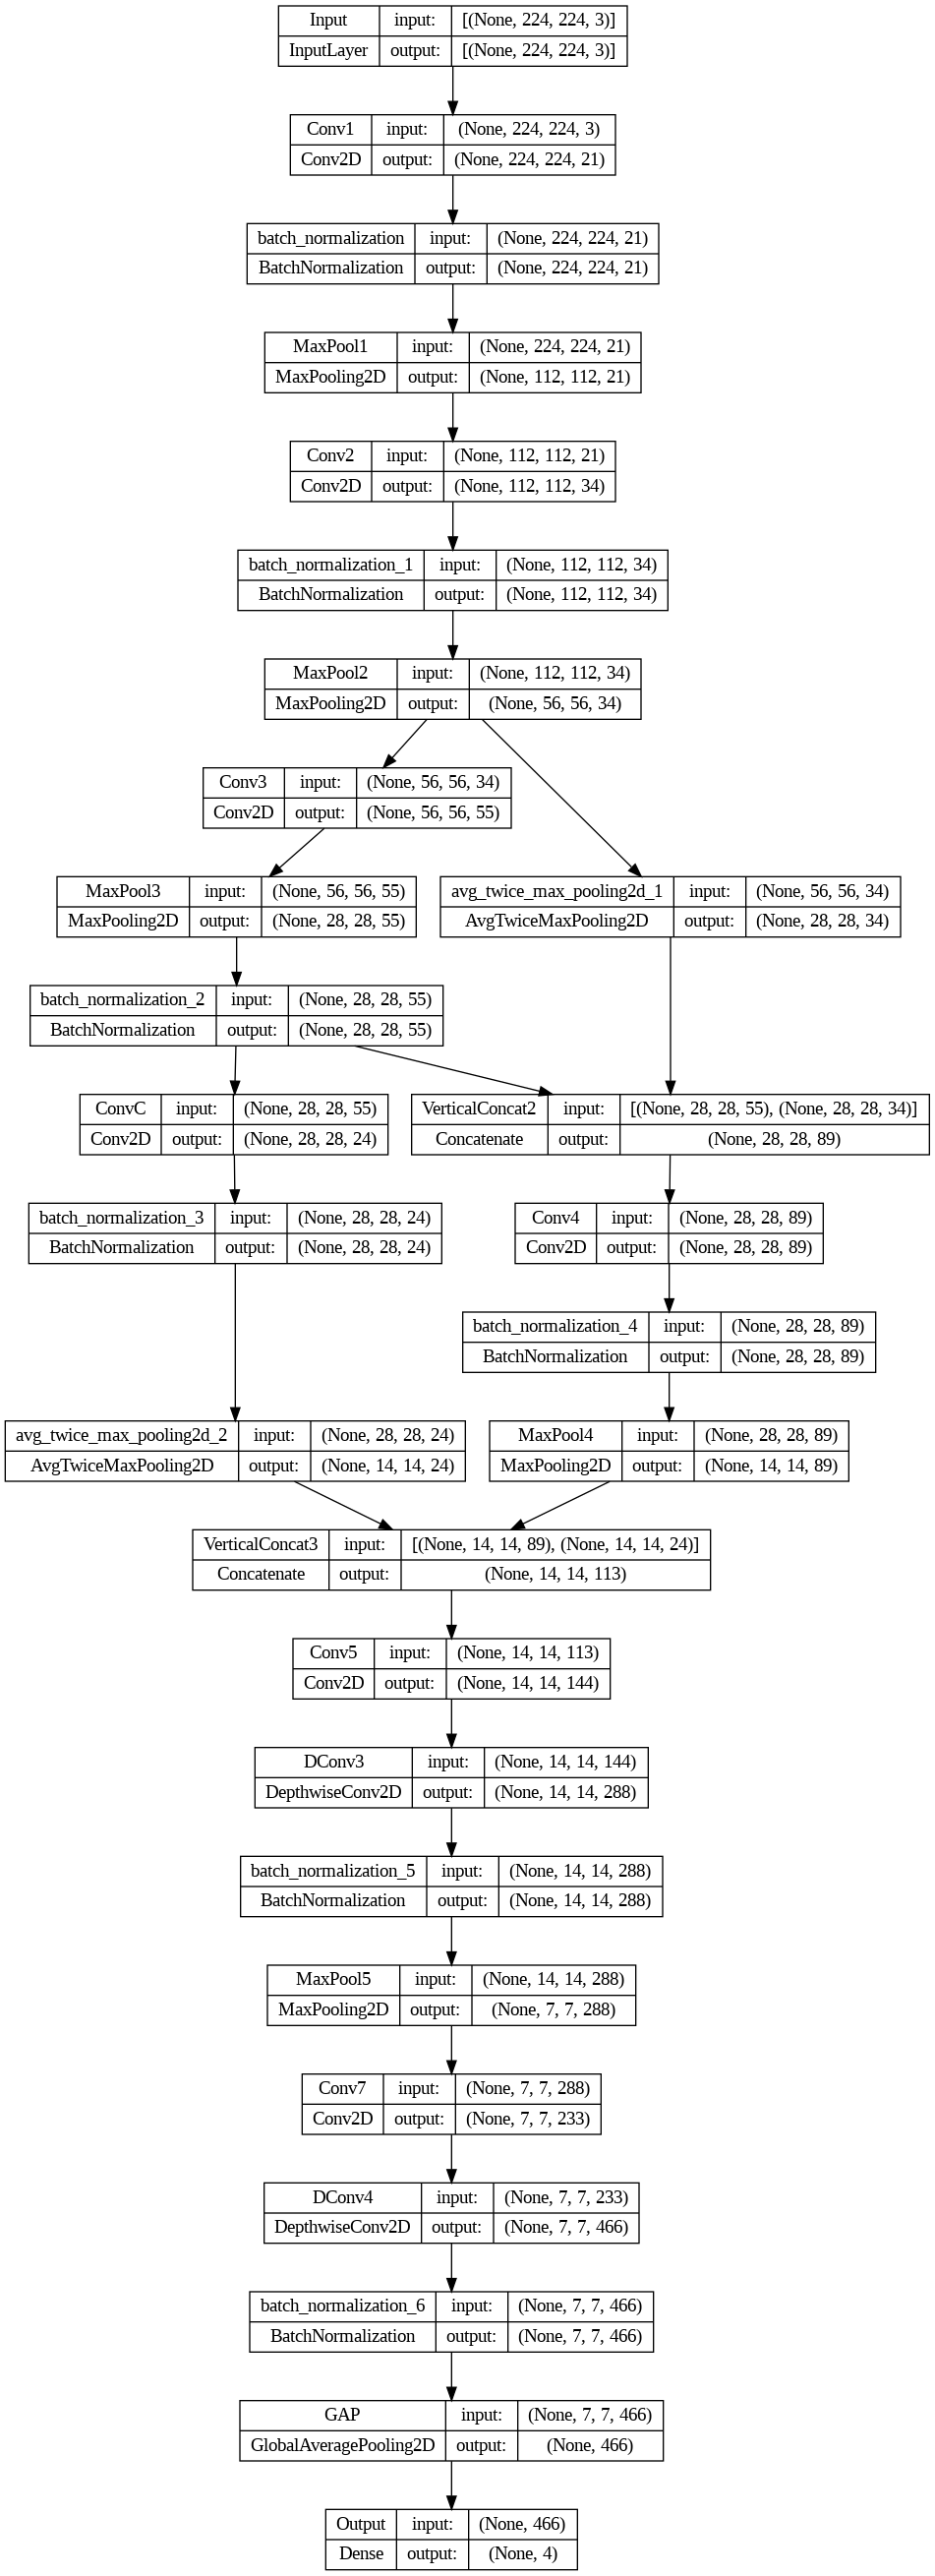

In [42]:
plot_model(model, show_shapes=True)

In [43]:
def create_metrics():
    """
    Creates instances of various metrics for evaluating model performance.

    Returns:
        tuple: A tuple of the metrics: (recall, precision, f1_score, auc, sensitivity, specificity, mcc).
    """
    @tf.function
    def f1_score(y_true, y_pred):
        """
        Calculates the F1 score.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: F1 score.
        """
        tp = true_positive(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    @tf.function
    def specificity(y_true, y_pred):
        """
        Calculates the specificity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Specificity.
        """
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)

        return tn / (tn + fp + K.epsilon())

    @tf.function
    def sensitivity(y_true, y_pred):
        """
        Calculates the sensitivity.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Sensitivity.
        """
        tp = true_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        return tp / (tp + fn + K.epsilon())

    @tf.function
    def mcc(y_true, y_pred):
        """
        Calculates the Matthews correlation coefficient (MCC).

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Matthews correlation coefficient.
        """
        tp = true_positive(y_true, y_pred)
        tn = true_negative(y_true, y_pred)
        fp = false_positive(y_true, y_pred)
        fn = false_negative(y_true, y_pred)

        numerator = (tp * tn - fp * fn)
        denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        return numerator / (denominator + K.epsilon())

    @tf.function
    def true_positive(y_true, y_pred):
        """
        Calculates the number of true positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true positives.
        """
        y_pred_pos, _, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_pos)

    @tf.function
    def false_positive(y_true, y_pred):
        """
        Calculates the number of false positives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false positives.
        """
        y_pred_pos, _, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_pos)

    @tf.function
    def false_negative(y_true, y_pred):
        """
        Calculates the number of false negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of false negatives.
        """
        _, y_pred_neg, y_pos, _ = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_pos * y_pred_neg)

    @tf.function
    def true_negative(y_true, y_pred):
        """
        Calculates the number of true negatives.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            Tensor: Number of true negatives.
        """
        _, y_pred_neg, _, y_neg = calculate_confusion_matrix(y_true, y_pred)
        return K.sum(y_neg * y_pred_neg)

    @tf.function
    def calculate_confusion_matrix(y_true, y_pred):
        """
        Calculates the components of the confusion matrix.

        Args:
            y_true: True labels.
            y_pred: Predicted labels.

        Returns:
            tuple: A tuple containing the components of the confusion matrix: (y_pred_pos, y_pred_neg, y_pos, y_neg).
        """
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        return y_pred_pos, y_pred_neg, y_pos, y_neg

    precision_metric = Precision()
    recall_metric = Recall()
    f1_score_metric = f1_score
    specificity_metric = specificity
    sensitivity_metric = sensitivity
    mcc_metric = mcc
    auc_metric = AUC()

    return (
        precision_metric,
        recall_metric,
        f1_score_metric,
        specificity_metric,
        sensitivity_metric,
        mcc_metric,
        auc_metric,
    )

In [44]:
model.compile(
    optimizer = Adam(learning_rate = 5e-4),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy", create_metrics()]
)

In [45]:
class TimeCallback(tf.keras.callbacks.Callback):
    """Custom callback to record epoch times and total training time."""

    def on_train_begin(self, logs=None):
        """Initialize training start time and epoch times."""
        self.train_start_time = time.perf_counter()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        """Record start time of each epoch."""
        self.epoch_start_time = time.perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        """Calculate and store epoch time."""
        epoch_time = time.perf_counter() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_end(self, logs=None):
        """Calculate total training time."""
        self.total_train_time = time.perf_counter() - self.train_start_time

# Create an instance of the TimeCallback
time_callback = TimeCallback()

In [46]:
TOTAL_EPOCHS = 40

start_time = perf_counter()
history = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[time_callback]
)
end_time = perf_counter()

Epoch 1/40
522/522 [==============================] - 66s 64ms/step - loss: 0.7224 - accuracy: 0.7275 - precision: 0.7915 - recall: 0.6307 - f1_score: 0.6897 - specificity: 0.9446 - sensitivity: 0.6307 - mcc: 0.6187 - auc: 0.9119 - val_loss: 1.0029 - val_accuracy: 0.5772 - val_precision: 0.6527 - val_recall: 0.4090 - val_f1_score: 0.4954 - val_specificity: 0.9275 - val_sensitivity: 0.4090 - val_mcc: 0.4003 - val_auc: 0.8200
Epoch 2/40
522/522 [==============================] - 35s 67ms/step - loss: 0.3656 - accuracy: 0.8724 - precision: 0.8944 - recall: 0.8458 - f1_score: 0.8671 - specificity: 0.9667 - sensitivity: 0.8458 - mcc: 0.8275 - auc: 0.9770 - val_loss: 0.4507 - val_accuracy: 0.8333 - val_precision: 0.8714 - val_recall: 0.7948 - val_f1_score: 0.8283 - val_specificity: 0.9609 - val_sensitivity: 0.7948 - val_mcc: 0.7792 - val_auc: 0.9655
Epoch 3/40
522/522 [==============================] - 23s 44ms/step - loss: 0.1891 - accuracy: 0.9370 - precision: 0.9463 - recall: 0.9239 - f1_

In [47]:
execution_time_parts = []
avg_time_parts = []

for unit in [(3600, 'hours'), (60, 'minutes'), (1, 'seconds'), (0.001, 'milliseconds')]:
    total_value = int(time_callback.total_train_time // unit[0])
    avg_value = int(np.mean(time_callback.epoch_times) // unit[0])

    if total_value > 0 or unit[0] == 0.001:
        execution_time_parts.append((total_value, unit[1]))
    if avg_value > 0 or unit[0] == 0.001:
        avg_time_parts.append((avg_value, unit[1]))

    time_callback.total_train_time -= total_value * unit[0]
    time_callback.epoch_times = [time - avg_value * unit[0] for time in time_callback.epoch_times]

execution_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in execution_time_parts if value > 0
])

avg_time_string = ", ".join([
    f"{value:02d} {unit_str}" for value, unit_str in avg_time_parts if value > 0
])

print(f"Model training took {execution_time_string}")
print(f"Average time per epoch: {avg_time_string}")

Model training took 15 minutes, 46 seconds, 315 milliseconds
Average time per epoch: 23 seconds, 641 milliseconds


In [56]:
_ = model.evaluate(test_generator, steps=test_steps)

65/65 [==============================] - 3s 41ms/step - loss: 0.2148 - accuracy: 0.9670 - precision: 0.9669 - recall: 0.9631 - f1_score: 0.9651 - specificity: 0.9891 - sensitivity: 0.9635 - mcc: 0.9537 - auc: 0.9891


In [49]:
def plot_metrics(hist, metric_name_list):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        hist: a Keras History object containing the training history
        metric_name_list: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_name_list)

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, len(hist.history[metric_name_list[0]]) + 1)

    for ax, metric_n in zip(axes, metric_name_list):
        metric = hist.history[metric_n]
        v_metric = hist.history[f"val_{metric_n}"]

        ax.plot(rng, metric, label=metric_n)
        ax.plot(rng, v_metric, label=f"val_{metric_n}")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_n in ("auc", "mcc"):
            ax.set_ylabel(metric_n.upper())
            ax.set_title(metric_n.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_n.capitalize())
            ax.set_title(metric_n.capitalize() + " vs Epochs")

        max_loss = max(max(metric), max(v_metric))
        min_loss = min(min(metric), min(v_metric))
        y_max = math.ceil(max_loss)

        if min_loss > 0 or max_loss > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_loss, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, len(metric))

    plt.tight_layout()

    plt.show()

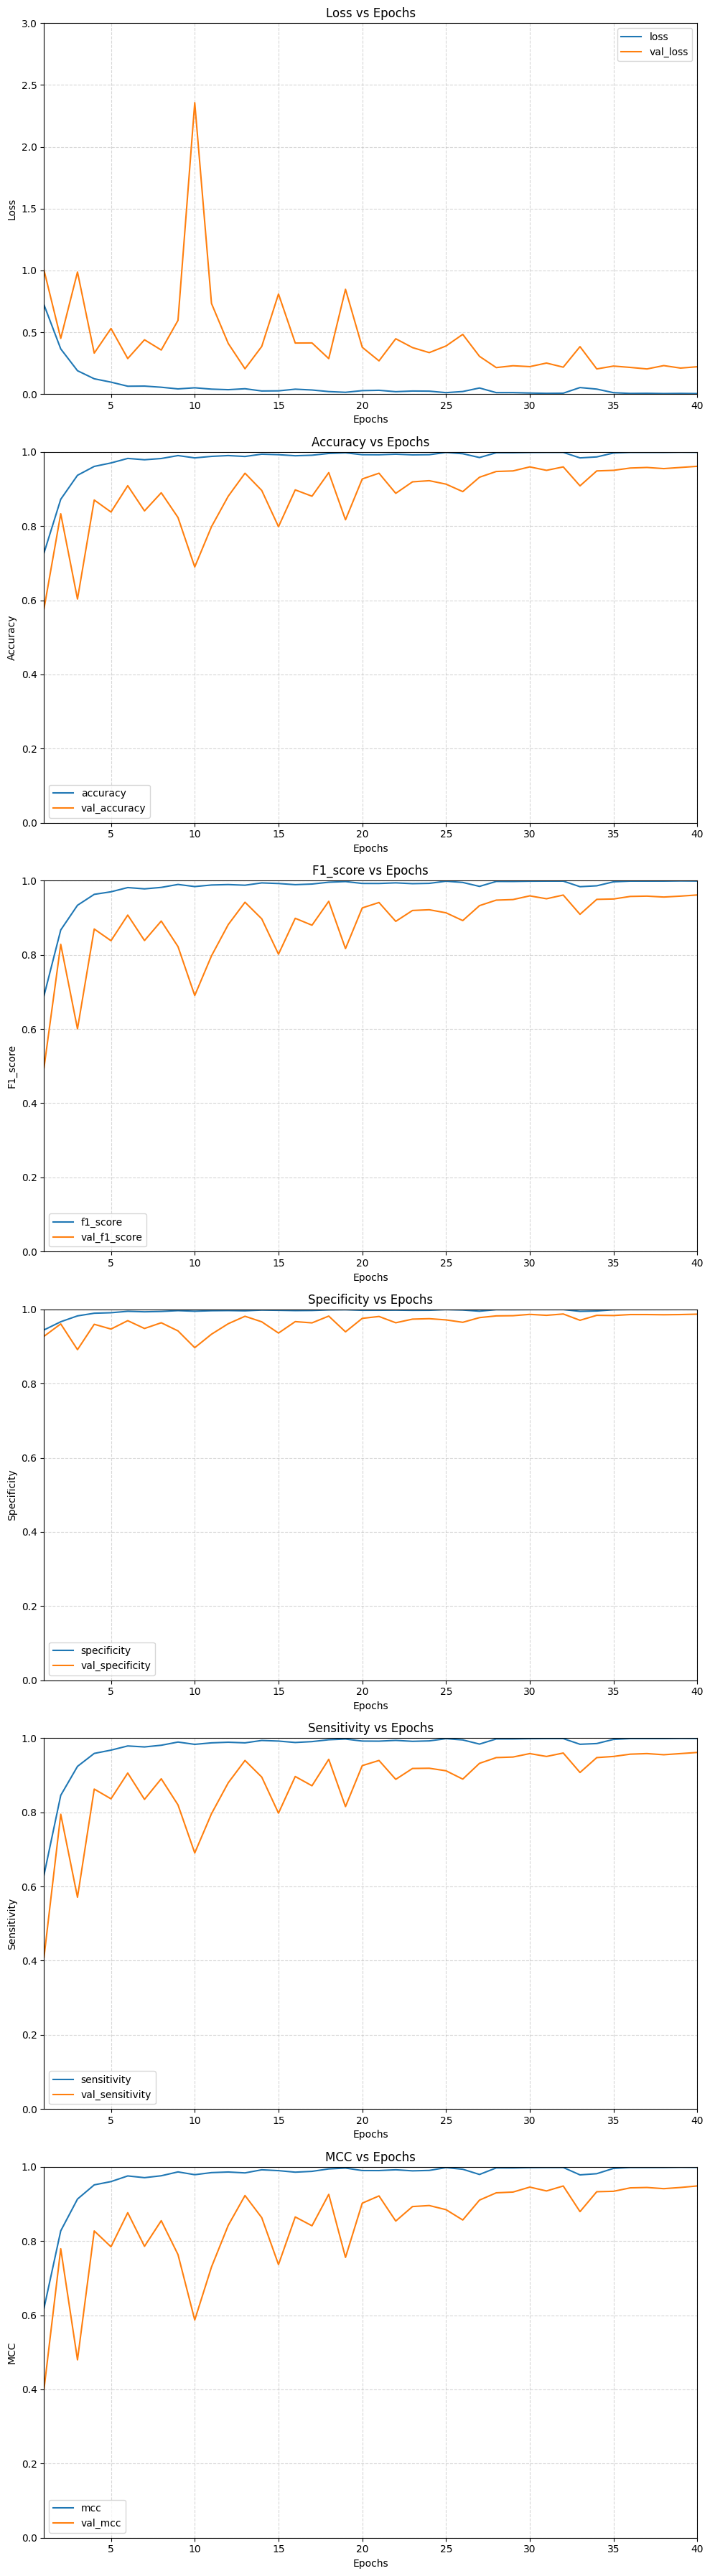

In [50]:
metric_names = ["loss", "accuracy","f1_score",
                "specificity", "sensitivity", "mcc"]
plot_metrics(history, metric_names)

In [51]:
def generate_classification_report(model, test_generator, test_steps, batch_size, target_names):
    """
    Generate a classification report, accuracy, and number of errors for a given model and test generator.

    Args:
        model (object): The trained model.
        test_generator (object): The test data generator.
        test_steps (int): The number of steps to iterate over the test generator.
        batch_size (int): The batch size for generating predictions.
        target_names (list): List of target class names for the classification report.

    Returns:
        tuple: A tuple containing true labels, predicted labels, and the classification report.
    """
    predicted_labels = []
    true_labels = []

    for i in range(test_steps):
        batch_data, batch_true_labels = next(test_generator)

        batch_predicted_labels = model.predict_on_batch(batch_data)
        batch_predicted_labels = np.argmax(batch_predicted_labels, axis=1)

        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(batch_true_labels)

    true_labels = np.array(true_labels)

    if len(true_labels[0]) > 1:
        true_labels = np.argmax(true_labels, axis=1)

    report = classification_report(
        true_labels,
        predicted_labels,
        target_names=target_names,
        digits=4,
        zero_division=1
    )

    accuracy = accuracy_score(true_labels, predicted_labels)
    num_errors = np.sum(true_labels != predicted_labels)

    print(report)
    print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

    return true_labels, predicted_labels

In [52]:
true_labels, predicted_labels = generate_classification_report(
    model, test_generator, test_steps, BATCH_SIZE, formatted_class_names
)

                  precision    recall  f1-score   support

        No Tumor     0.9408    0.9662    0.9533       148
Meningioma Tumor     0.9855    0.9189    0.9510       148
    Glioma Tumor     0.9506    1.0000    0.9747        77
 Pituitary Tumor     0.9861    1.0000    0.9930       142

        accuracy                         0.9670       515
       macro avg     0.9658    0.9713    0.9680       515
    weighted avg     0.9676    0.9670    0.9668       515

There were 17 errors in 515 tests for an accuracy of  96.70


In [53]:
def confusion_matrix(true_labels, predicted_labels, num_classes):
    """
    Compute the confusion matrix.

    Args:
        true_labels (list or numpy.ndarray): Array-like object of true labels.
        predicted_labels (list or numpy.ndarray): Array-like object of predicted labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Confusion matrix.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    np.add.at(cm, (true_labels, predicted_labels), 1)
    return cm

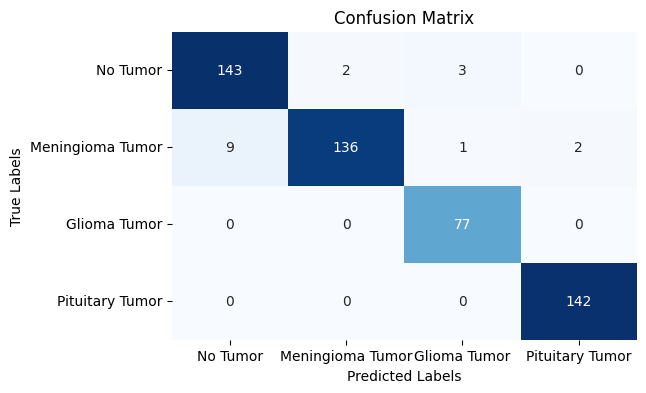

In [54]:
cm = confusion_matrix(true_labels, predicted_labels, num_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=formatted_class_names, yticklabels=formatted_class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()